In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
import json
import numpy as np
from typing import Dict, Tuple, Optional

curr_dir = os.path.abspath(os.path.join(sys.path[0]))
parent_dir = os.path.abspath(os.path.join(sys.path[0], ".."))
sys.path.append(parent_dir)

import datasets


class SumPool2d(nn.Module):
    def __init__(self, kernel_size: int, stride: int):
        super(SumPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.avg_pool = nn.AvgPool2d(kernel_size, stride)

    def forward(self, x):
        return self.avg_pool(x) * (self.kernel_size ** 2)


def update_dict(d: Dict, keys: np.ndarray, values: np.ndarray) -> Dict:
    keys = keys.tolist() if isinstance(keys, np.ndarray) else keys
    values = values.tolist() if isinstance(values, np.ndarray) else values
    for k, v in zip(keys, values):
        if k in d.keys():
            d[k] += v
        else:
            d[k] = v

    return d


device = "mps"

filter_64 = SumPool2d(kernel_size=64, stride=1).to(device)
filter_32 = SumPool2d(kernel_size=32, stride=1).to(device)
filter_16 = SumPool2d(kernel_size=16, stride=1).to(device)
filter_8 = SumPool2d(kernel_size=8, stride=1).to(device)
filter_4 = SumPool2d(kernel_size=4, stride=1).to(device)
max_size = 6144

In [2]:
def get_counts(name: str, max_size: Optional[int]=None) -> Tuple[Dict[int, int], Dict[int, int], Dict[int, int], Dict[int, int], Dict[int, int], Dict, Dict, Dict, Dict, Dict]:
    counts_4, counts_8, counts_16, counts_32, counts_64 = {}, {}, {}, {}, {}
    max_counts_4, max_counts_8, max_counts_16, max_counts_32, max_counts_64 = {}, {}, {}, {}, {}

    counts_dir = os.path.join(curr_dir, "counts")
    counts_dir = os.path.join(counts_dir, name) if max_size is None else os.path.join(counts_dir, f"{name}_{max_size}")
    os.makedirs(counts_dir, exist_ok=True)

    counts_4_path = os.path.join(counts_dir, "counts_4.json")
    counts_8_path = os.path.join(counts_dir, "counts_8.json")
    counts_16_path = os.path.join(counts_dir, "counts_16.json")
    counts_32_path = os.path.join(counts_dir, "counts_32.json")
    counts_64_path = os.path.join(counts_dir, "counts_64.json")

    max_counts_4_path = os.path.join(counts_dir, "max_counts_4.json")
    max_counts_8_path = os.path.join(counts_dir, "max_counts_8.json")
    max_counts_16_path = os.path.join(counts_dir, "max_counts_16.json")
    max_counts_32_path = os.path.join(counts_dir, "max_counts_32.json")
    max_counts_64_path = os.path.join(counts_dir, "max_counts_64.json")

    existence = all([
        os.path.exists(counts_4_path),
        os.path.exists(counts_8_path),
        os.path.exists(counts_16_path),
        os.path.exists(counts_32_path),
        os.path.exists(counts_64_path),
        os.path.exists(max_counts_4_path),
        os.path.exists(max_counts_8_path),
        os.path.exists(max_counts_16_path),
        os.path.exists(max_counts_32_path),
        os.path.exists(max_counts_64_path)
    ])
    if existence:
        with open(counts_4_path, "r") as f:
            counts_4 = json.load(f)
            counts_4 = {int(k): v for k, v in counts_4.items()}
        with open(max_counts_4_path, "r") as f:
            max_counts_4 = json.load(f)
        with open(counts_8_path, "r") as f:
            counts_8 = json.load(f)
            counts_8 = {int(k): v for k, v in counts_8.items()}
        with open(max_counts_8_path, "r") as f:
            max_counts_8 = json.load(f)
        with open(counts_16_path, "r") as f:
            counts_16 = json.load(f)
            counts_16 = {int(k): v for k, v in counts_16.items()}
        with open(max_counts_16_path, "r") as f:
            max_counts_16 = json.load(f)
        with open(counts_32_path, "r") as f:
            counts_32 = json.load(f)
            counts_32 = {int(k): v for k, v in counts_32.items()}
        with open(max_counts_32_path, "r") as f:
            max_counts_32 = json.load(f)
        with open(counts_64_path, "r") as f:
            counts_64 = json.load(f)
            counts_64 = {int(k): v for k, v in counts_64.items()}
        with open(max_counts_64_path, "r") as f:
            max_counts_64 = json.load(f)
    else:
        dataset = datasets.Crowd(dataset=name, split="train", transforms=None, percentage=100, return_filename=True)
        print(f"Counting {name} dataset")
        counts_4, counts_8, counts_16, counts_32, counts_64 = {}, {}, {}, {}, {}
        max_counts_4 = {"max": 0., "name": None, "x": None, "y": None}
        max_counts_8 = {"max": 0., "name": None, "x": None, "y": None}
        max_counts_16 = {"max": 0., "name": None, "x": None, "y": None}
        max_counts_32 = {"max": 0., "name": None, "x": None, "y": None}
        max_counts_64 = {"max": 0., "name": None, "x": None, "y": None}

        for i in tqdm(range(len(dataset))):
            _, _, density, img_name = dataset[i]
            assert len(density.shape) == 3 and density.shape[0] == 1, f"Expected density to be a 3D tensor (1, H, W), got {density.shape}"
            density = density.unsqueeze(0).to(device)  # Add batch dimension
            window_4, window_8, window_16, window_32, window_64 = filter_4(density), filter_8(density), filter_16(density), filter_32(density), filter_64(density)
            window_4, window_8, window_16, window_32, window_64 = torch.squeeze(window_4), torch.squeeze(window_8), torch.squeeze(window_16), torch.squeeze(window_32), torch.squeeze(window_64)
            if window_4.max().item() > max_counts_4["max"]:
                max_counts_4["max"] = window_4.max().item()
                max_counts_4["name"] = img_name
                x, y = torch.where(window_4 == window_4.max())
                x, y = x[0].item(), y[0].item()
                max_counts_4["x"] = x
                max_counts_4["y"] = y
            if window_8.max().item() > max_counts_8["max"]:
                max_counts_8["max"] = window_8.max().item()
                max_counts_8["name"] = img_name
                x, y = torch.where(window_8 == window_8.max())
                x, y = x[0].item(), y[0].item()
                max_counts_8["x"] = x
                max_counts_8["y"] = y
            if window_16.max().item() > max_counts_16["max"]:
                max_counts_16["max"] = window_16.max().item()
                max_counts_16["name"] = img_name
                x, y = torch.where(window_16 == window_16.max())
                x, y = x[0].item(), y[0].item()
                max_counts_16["x"] = x
                max_counts_16["y"] = y
            if window_32.max().item() > max_counts_32["max"]:
                max_counts_32["max"] = window_32.max().item()
                max_counts_32["name"] = img_name
                x, y = torch.where(window_32 == window_32.max())
                x, y = x[0].item(), y[0].item()
                max_counts_32["x"] = x
                max_counts_32["y"] = y
            if window_64.max().item() > max_counts_64["max"]:
                max_counts_64["max"] = window_64.max().item()
                max_counts_64["name"] = img_name
                x, y = torch.where(window_64 == window_64.max())
                x, y = x[0].item(), y[0].item()
                max_counts_64["x"] = x
                max_counts_64["y"] = y

            window_4 = window_4.view(-1).cpu().numpy().astype(int)
            window_8 = window_8.view(-1).cpu().numpy().astype(int)
            window_16 = window_16.view(-1).cpu().numpy().astype(int)
            window_32 = window_32.view(-1).cpu().numpy().astype(int)
            window_64 = window_64.view(-1).cpu().numpy().astype(int)
            #.view(-1).cpu().numpy().astype(int)

            uniques_, counts_ = np.unique(window_4, return_counts=True)
            counts_4 = update_dict(counts_4, uniques_, counts_)
            uniques_, counts_ = np.unique(window_8, return_counts=True)
            counts_8 = update_dict(counts_8, uniques_, counts_)
            uniques_, counts_ = np.unique(window_16, return_counts=True)
            counts_16 = update_dict(counts_16, uniques_, counts_)
            uniques_, counts_ = np.unique(window_32, return_counts=True)
            counts_32 = update_dict(counts_32, uniques_, counts_)
            uniques_, counts_ = np.unique(window_64, return_counts=True)
            counts_64 = update_dict(counts_64, uniques_, counts_)


        with open(counts_4_path, "w") as f:
            json.dump(counts_4, f)
        with open(counts_8_path, "w") as f:
            json.dump(counts_8, f)
        with open(counts_16_path, "w") as f:
            json.dump(counts_16, f)
        with open(counts_32_path, "w") as f:
            json.dump(counts_32, f)
        with open(counts_64_path, "w") as f:
            json.dump(counts_64, f)
        
        with open(max_counts_4_path, "w") as f:
            json.dump(max_counts_4, f)
        with open(max_counts_8_path, "w") as f:
            json.dump(max_counts_8, f)
        with open(max_counts_16_path, "w") as f:
            json.dump(max_counts_16, f)
        with open(max_counts_32_path, "w") as f:
            json.dump(max_counts_32, f)
        with open(max_counts_64_path, "w") as f:
            json.dump(max_counts_64, f)

    print(f"Window 4: min: {min(counts_4.keys())}, max: {max(counts_4.keys())}")
    print(f"Window 8: min: {min(counts_8.keys())}, max: {max(counts_8.keys())}")
    print(f"Window 16: min: {min(counts_16.keys())}, max: {max(counts_16.keys())}")
    print(f"Window 32: min: {min(counts_32.keys())}, max: {max(counts_32.keys())}")
    print(f"Window 64: min: {min(counts_64.keys())}, max: {max(counts_64.keys())}")
    print(f"Max counts 4: {max_counts_4}")
    print(f"Max counts 8: {max_counts_8}")
    print(f"Max counts 16: {max_counts_16}")
    print(f"Max counts 32: {max_counts_32}")
    print(f"Max counts 64: {max_counts_64}")
    return counts_4, counts_8, counts_16, counts_32, counts_64, max_counts_4, max_counts_8, max_counts_16, max_counts_32, max_counts_64

In [3]:
sha_counts_4, sha_counts_8, sha_counts_16, sha_counts_32, sha_counts_64, sha_max_counts_4, sha_max_counts_8, sha_max_counts_16, sha_max_counts_32, sha_max_counts_64 = get_counts("sha")
shb_counts_4, shb_counts_8, shb_counts_16, shb_counts_32, shb_counts_64, shb_max_counts_4, shb_max_counts_8, shb_max_counts_16, shb_max_counts_32, shb_max_counts_64 = get_counts("shb")
qnrf_counts_4, qnrf_counts_8, qnrf_counts_16, qnrf_counts_32, qnrf_counts_64, qnrf_max_counts_4, qnrf_max_counts_8, qnrf_max_counts_16, qnrf_max_counts_32, qnrf_max_counts_64 = get_counts("qnrf", max_size)
nwpu_counts_4, nwpu_counts_8, nwpu_counts_16, nwpu_counts_32, nwpu_counts_64, nwpu_max_counts_4, nwpu_max_counts_8, nwpu_max_counts_16, nwpu_max_counts_32, nwpu_max_counts_64 = get_counts("nwpu", max_size)

Window 4: min: 0, max: 4
Window 8: min: 0, max: 9
Window 16: min: 0, max: 27
Window 32: min: 0, max: 65
Window 64: min: 0, max: 196
Max counts 4: {'max': 4.0, 'name': '007.jpg', 'x': 277, 'y': 155}
Max counts 8: {'max': 9.0, 'name': '034.jpg', 'x': 270, 'y': 339}
Max counts 16: {'max': 27.0, 'name': '120.jpg', 'x': 295, 'y': 760}
Max counts 32: {'max': 65.0, 'name': '120.jpg', 'x': 313, 'y': 651}
Max counts 64: {'max': 196.0, 'name': '120.jpg', 'x': 301, 'y': 646}
Window 4: min: 0, max: 4
Window 8: min: 0, max: 9
Window 16: min: 0, max: 15
Window 32: min: 0, max: 35
Window 64: min: 0, max: 90
Max counts 4: {'max': 4.0, 'name': '148.jpg', 'x': 41, 'y': 548}
Max counts 8: {'max': 9.0, 'name': '148.jpg', 'x': 38, 'y': 550}
Max counts 16: {'max': 15.0, 'name': '191.jpg', 'x': 1, 'y': 256}
Max counts 32: {'max': 35.0, 'name': '191.jpg', 'x': 0, 'y': 254}
Max counts 64: {'max': 90.0, 'name': '191.jpg', 'x': 0, 'y': 254}
Window 4: min: 0, max: 4
Window 8: min: 0, max: 9
Window 16: min: 0, max

In [4]:
def show_distribution(window_size: int, title: str):
    if window_size == 4:
        counts = [sha_counts_4, shb_counts_4, nwpu_counts_4, qnrf_counts_4]
    elif window_size == 8:
        counts = [sha_counts_8, shb_counts_8, nwpu_counts_8, qnrf_counts_8]
    elif window_size == 16:
        counts = [sha_counts_16, shb_counts_16, nwpu_counts_16, qnrf_counts_16]
    elif window_size == 32:
        counts = [sha_counts_32, shb_counts_32, nwpu_counts_32, qnrf_counts_32]
    elif window_size == 64:
        counts = [sha_counts_64, shb_counts_64, nwpu_counts_64, qnrf_counts_64]

    all_keys = list(set([k for d in counts for k in d.keys()]))
    all_keys.sort()
    counts = [{k: d[k] if k in d.keys() else 0 for k in all_keys} for d in counts]

    # grouped bar chart of all datasets
    fig, ax = plt.subplots(1, 1, figsize=(50, 10), dpi=200)
    bar_width = 0.15
    bar_positions = np.arange(len(all_keys))

    for i, (name, values) in enumerate(zip(["sha", "shb", "nwpu", "qnrf", "jhu"], counts)):
        percentages = [v / sum(values.values()) * 100 for v in values.values()]
        rects = ax.bar(bar_positions + (i - len(counts) // 2) * bar_width, percentages, bar_width, label=name, log=True)
        for rect in rects:
            height = rect.get_height()
            ann = f"{height:.2f}" if height > 0.01 else f"{height:.2e}"
            ax.annotate(
                ann,
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=17,
                rotation=90
            )

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(all_keys)
    ax.set_xlabel("Crowd Size", fontsize=25)
    ax.set_ylabel("Frequency", fontsize=25)
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.tick_params(axis="both", which="minor", labelsize=15)

    ax.set_title(title, fontsize=30)
    ax.legend(fontsize=25)

    ax.spines[["top", "right"]].set_visible(False)

    # tight layout
    plt.tight_layout()
    # transparent background
    fig.patch.set_alpha(0.0)
    plt.show()


def show_extreme_area(max_counts, window_size, name, box_color="deeppink"):
    img_dir = os.path.join(parent_dir, "data", name, "train", "images")
    img_name = max_counts["name"]
    img_path = os.path.join(img_dir, img_name)
    x, y = max_counts["x"], max_counts["y"]

    img = plt.imread(img_path)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=200, tight_layout=True, frameon=False)
    ax.imshow(img)
    # draw a rectangle around the area of interest
    rect = plt.Rectangle((y, x), window_size, window_size, linewidth=1, edgecolor=box_color, facecolor="none")
    ax.add_patch(rect)
    ax.axis("off")
    plt.show()
    print(f"Data: {name}; Image: {img_name}")
    # save the image
    # fig.savefig(f"output/{name}_1_{img_name}", transparent=True, bbox_inches="tight", pad_inches=0)

    # crop a larger area around the area of interest
    fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=200, tight_layout=True)
    x_1, x_2 = max(0, x - window_size), min(img.shape[0], x + 2 * window_size)
    y_1, y_2 = max(0, y - window_size), min(img.shape[1], y + 2 * window_size)
    img_1 = img[x_1: x_2, y_1: y_2]
    ax.imshow(img_1)
    # draw a rectangle around the area of interest
    rect = plt.Rectangle((y - y_1, x - x_1), window_size, window_size, linewidth=1, edgecolor=box_color, facecolor="none")
    ax.add_patch(rect)
    ax.axis("off")
    plt.show()
    # save the image
    # fig.savefig(f"output/{name}_2_{img_name}", transparent=True, bbox_inches="tight", pad_inches=0)

    # crop the area of interest
    fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=200, tight_layout=True)
    img_2 = img[x: x + window_size, y: y + window_size]
    ax.imshow(img_2)
    ax.axis("off")
    print(f"Count: {max_counts['max']}")
    plt.show()
    # save the image
    # fig.savefig(f"output/{name}_3_{img_name}", transparent=True, bbox_inches="tight", pad_inches=0)

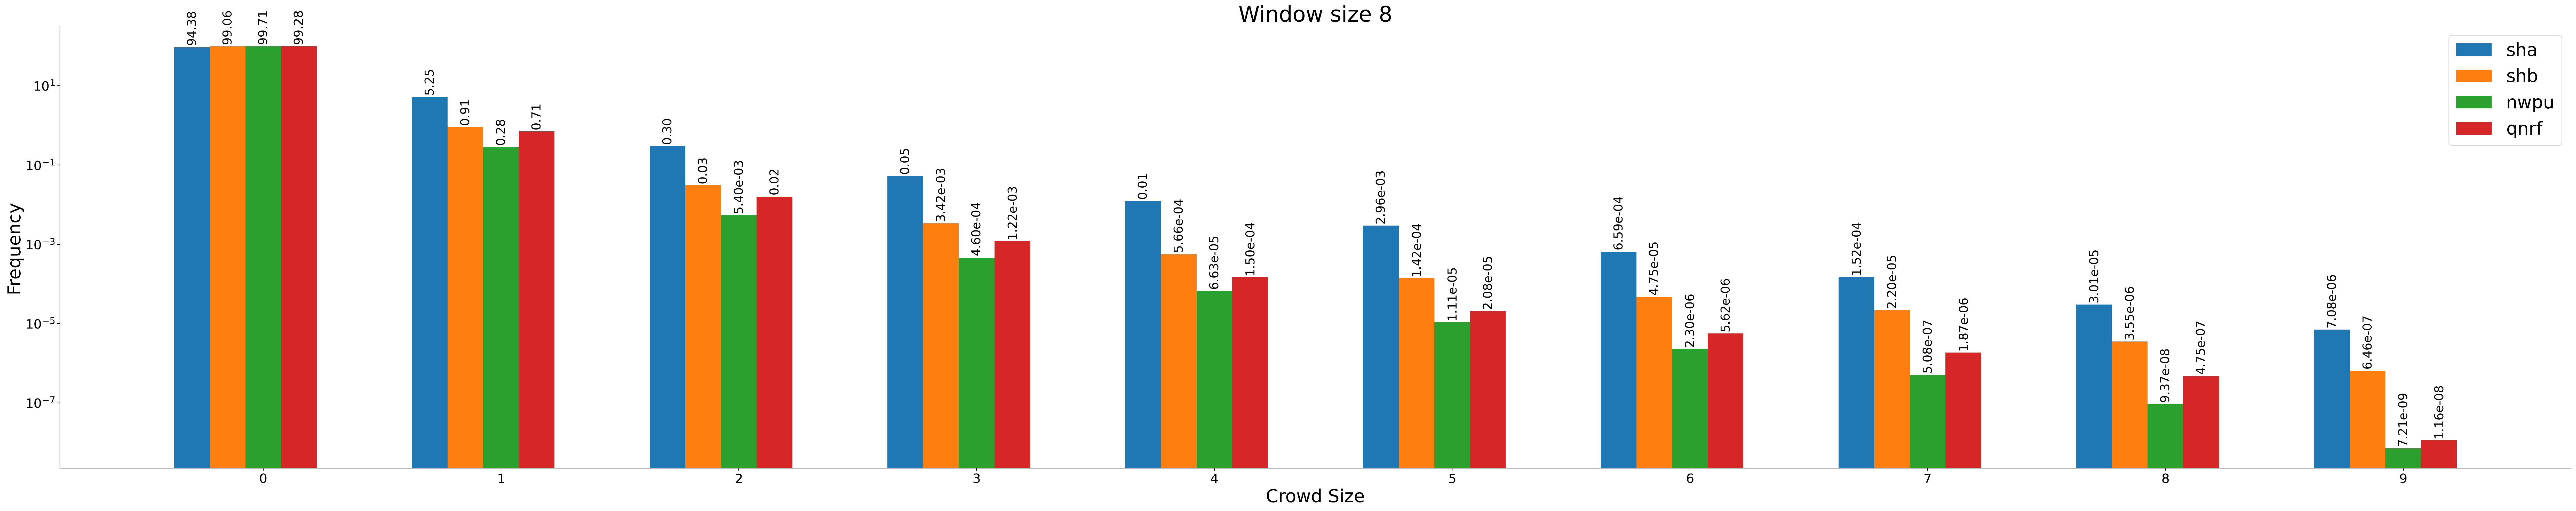

In [5]:
show_distribution(8, "Window size 8")

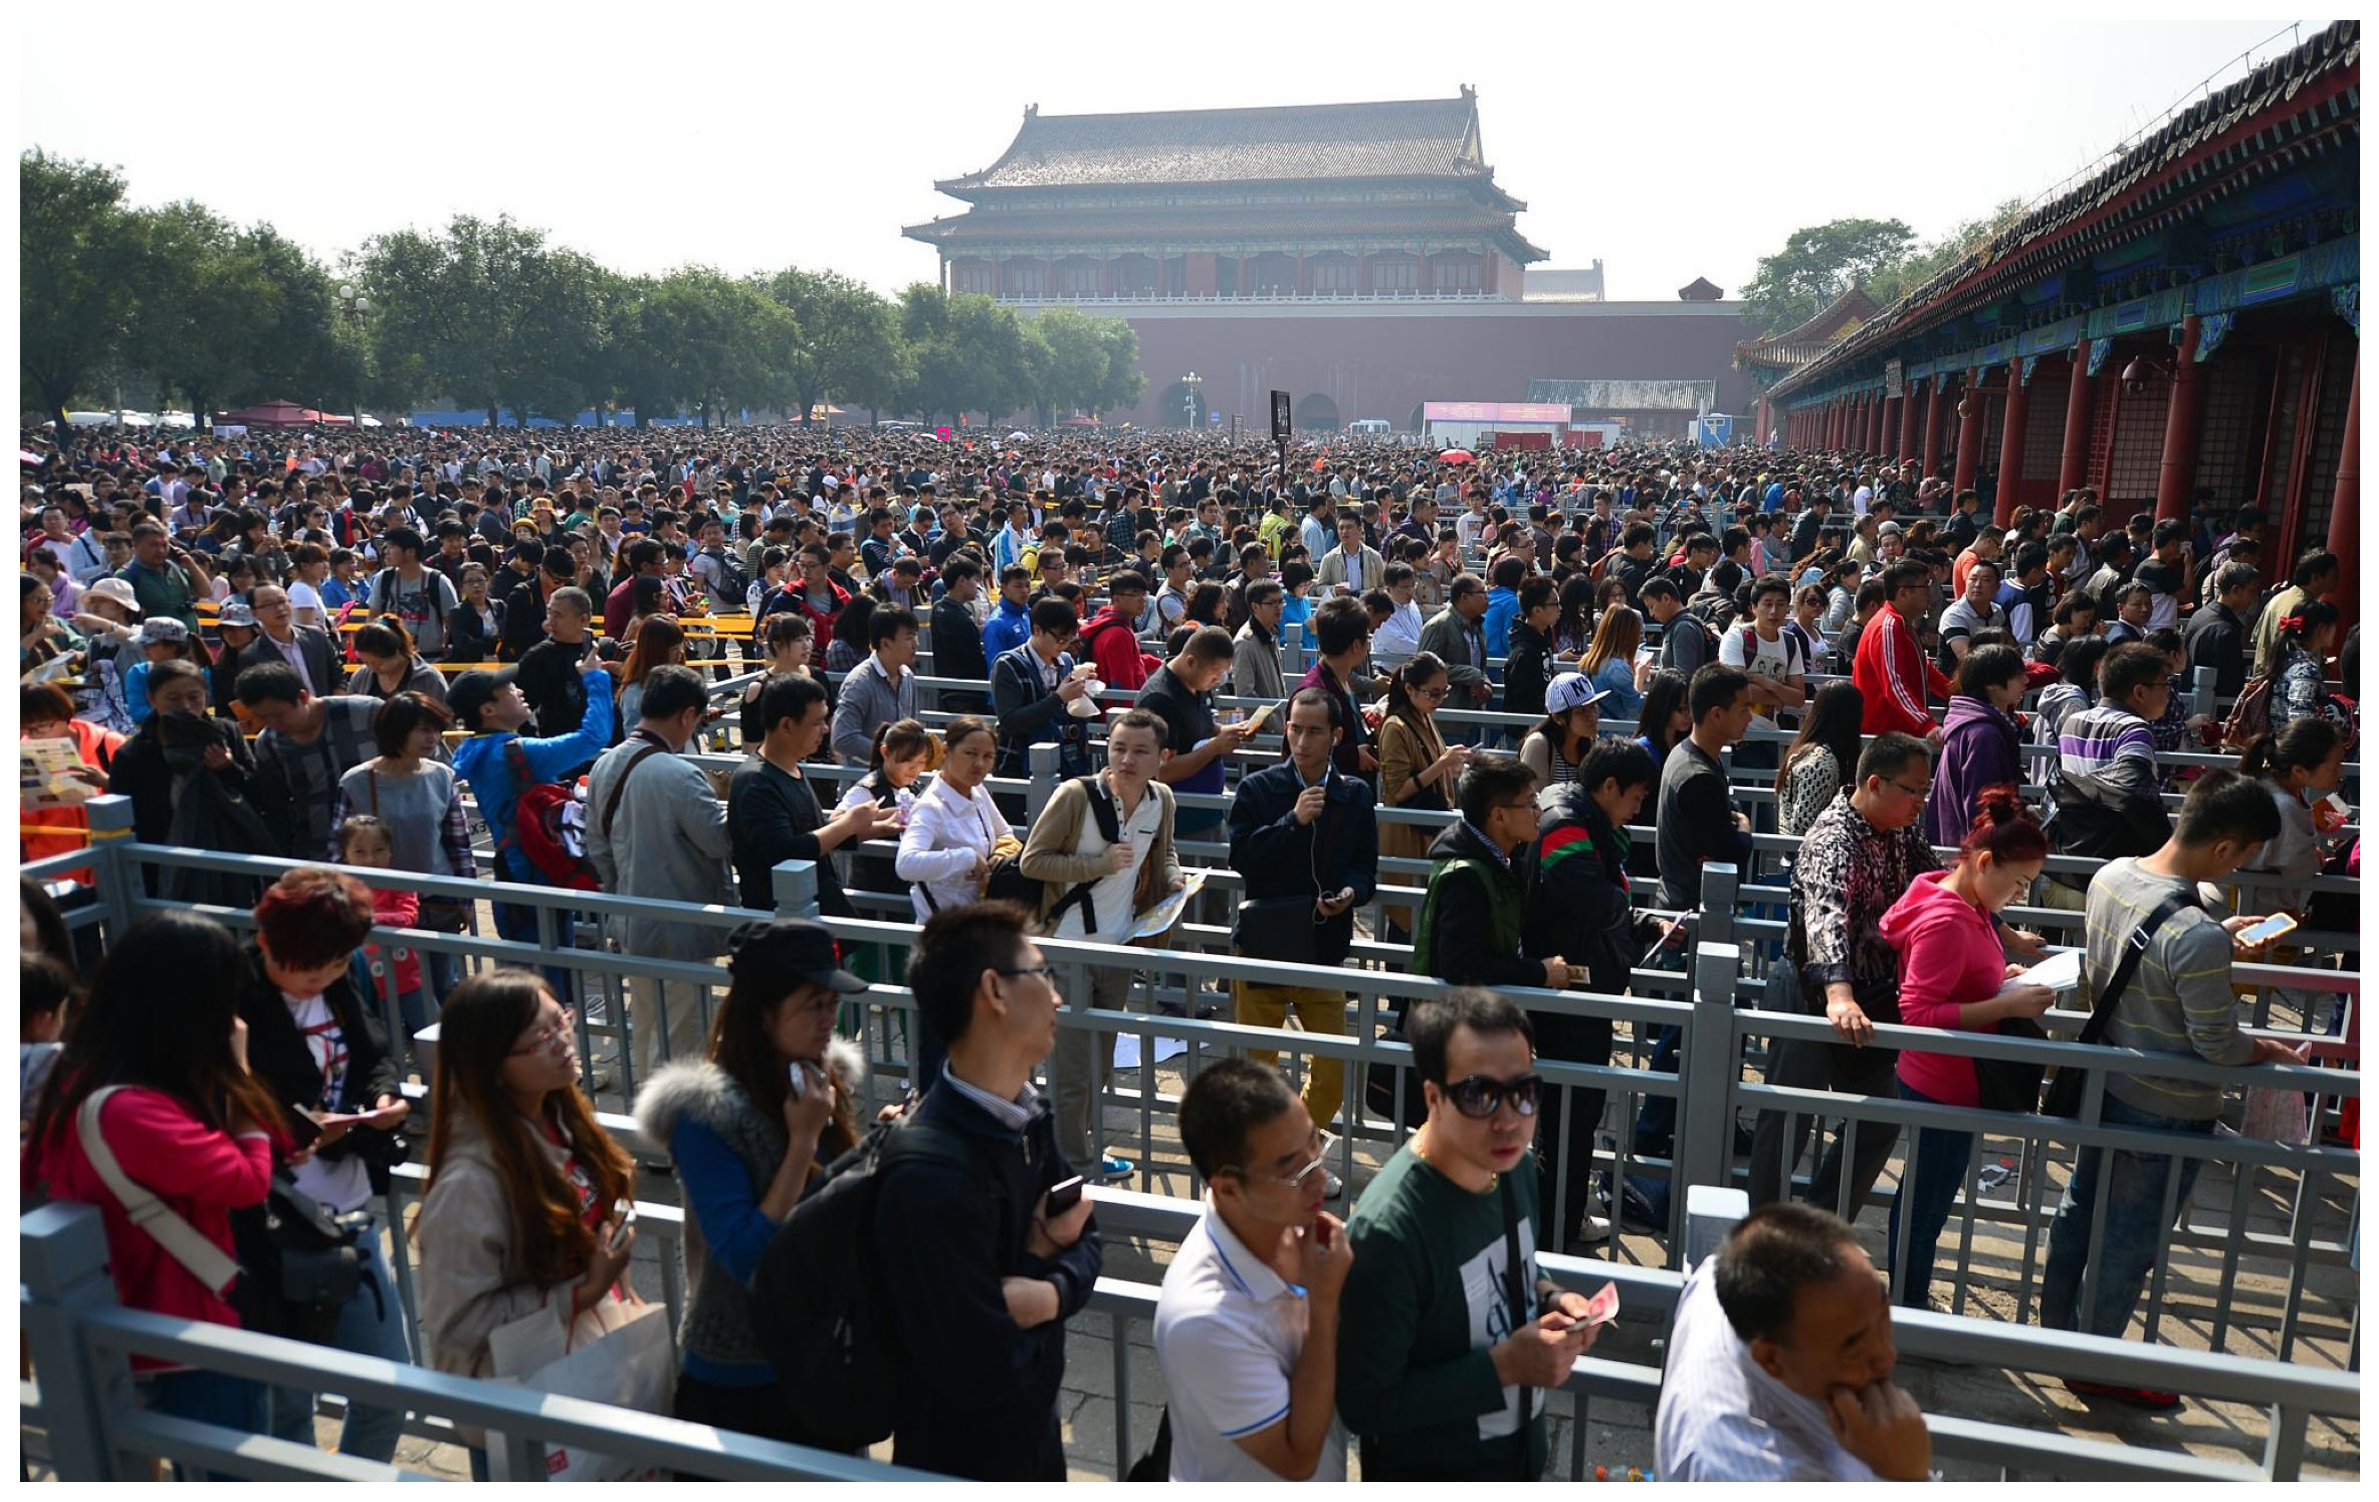

Data: nwpu; Image: 0671.jpg


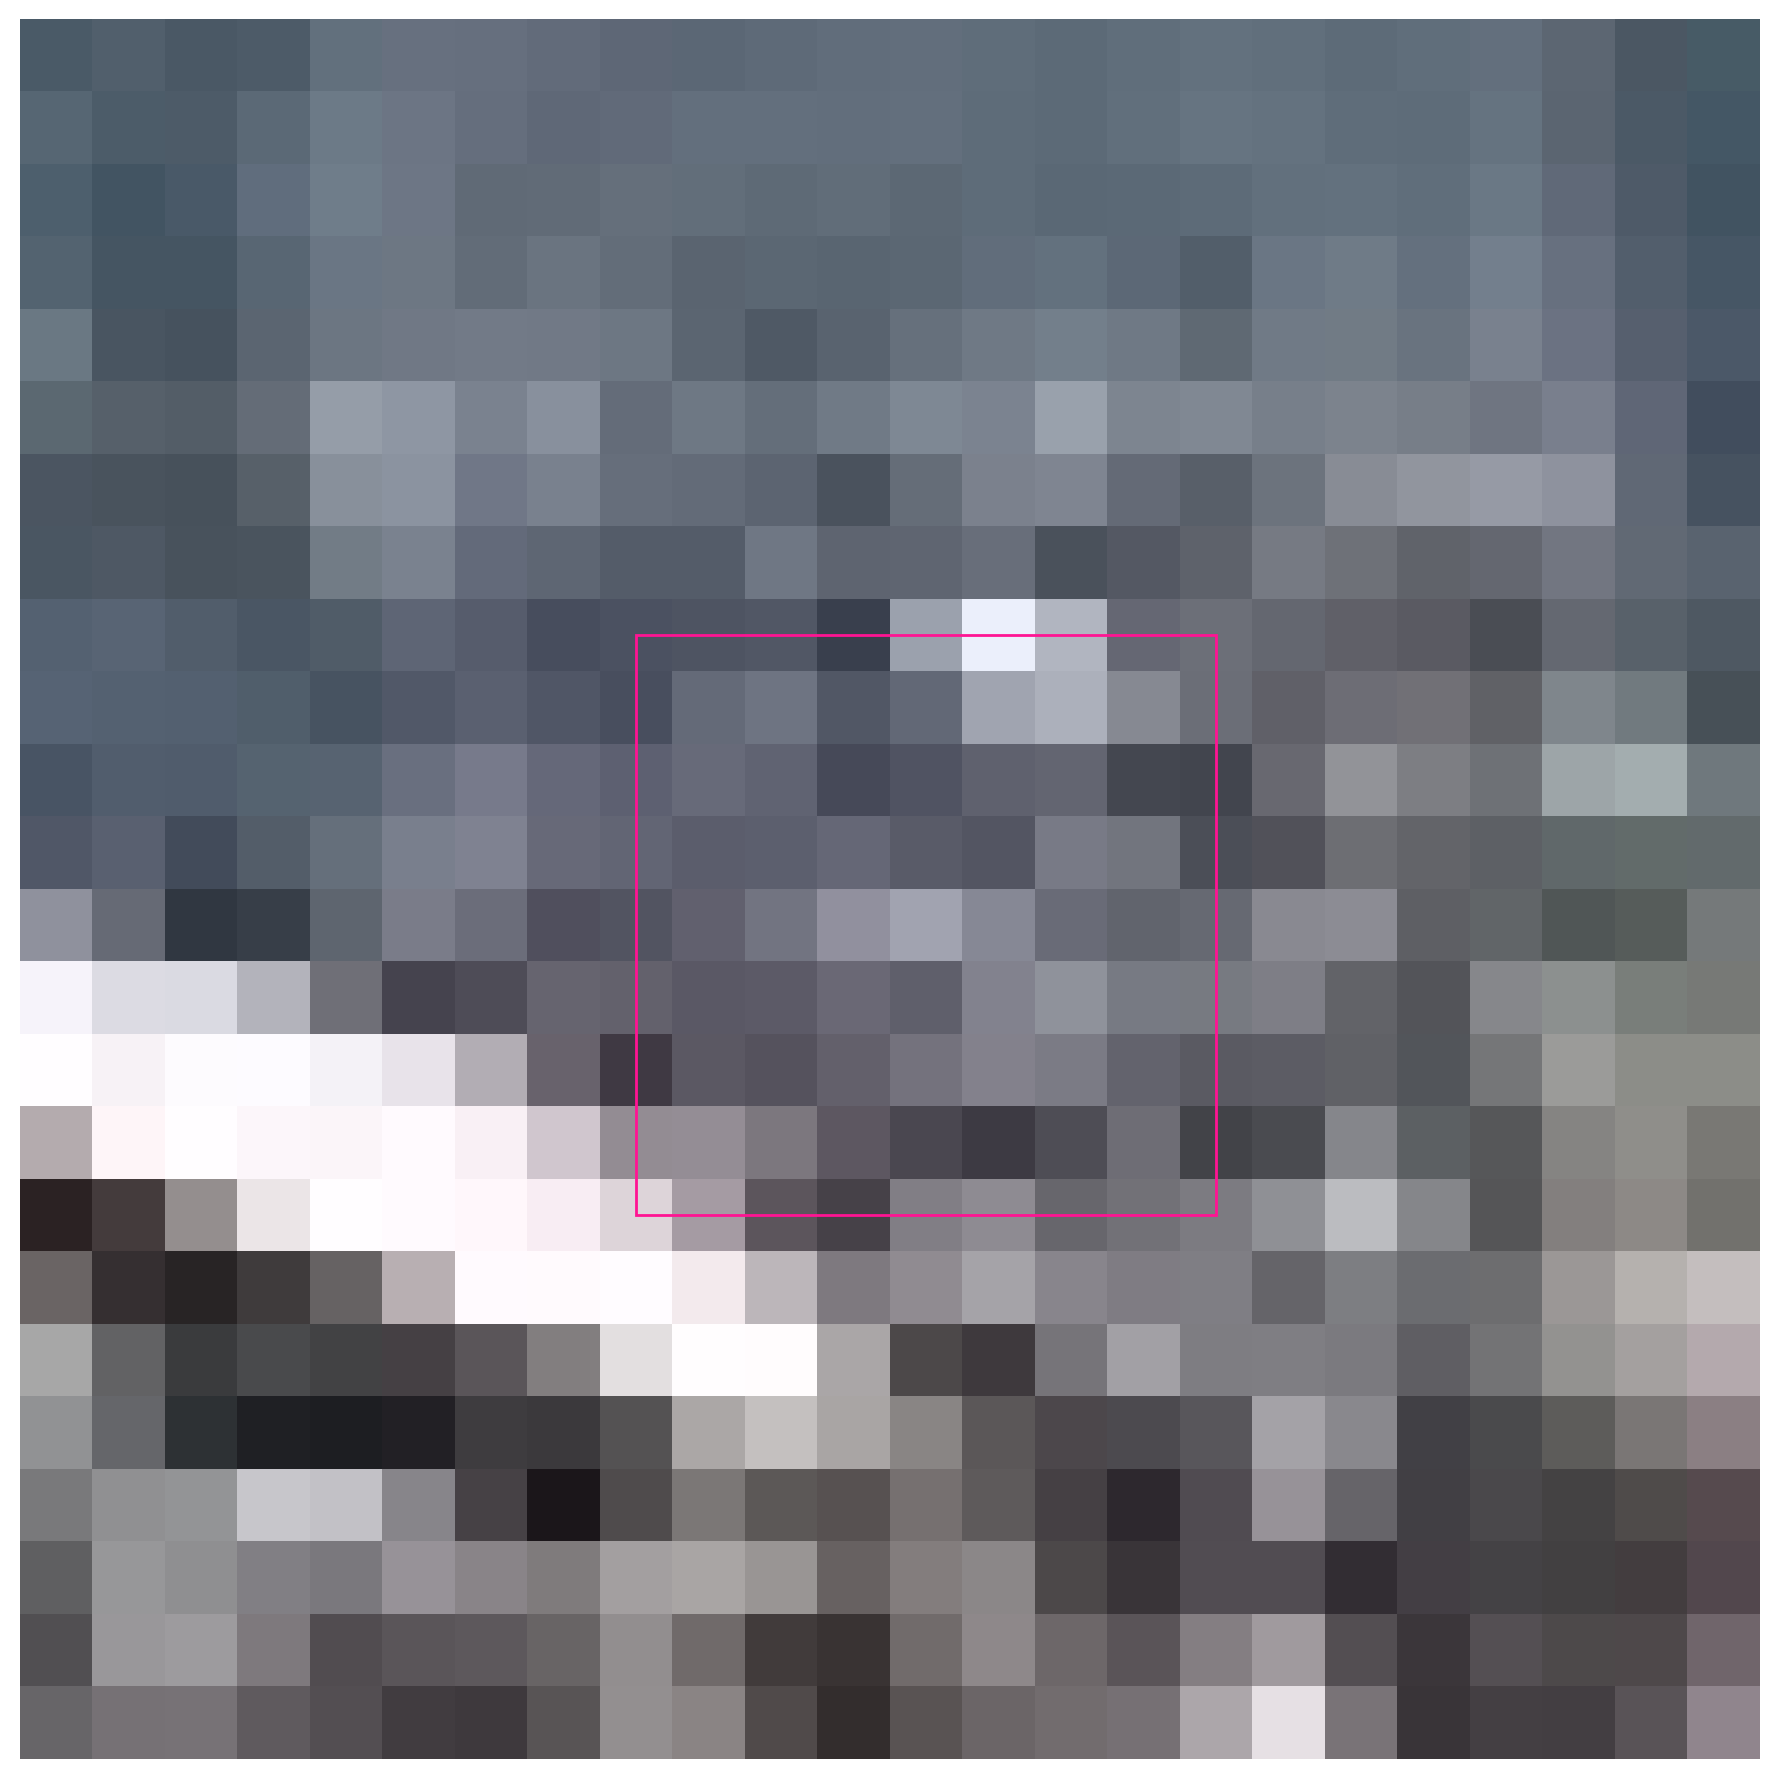

Count: 9.0


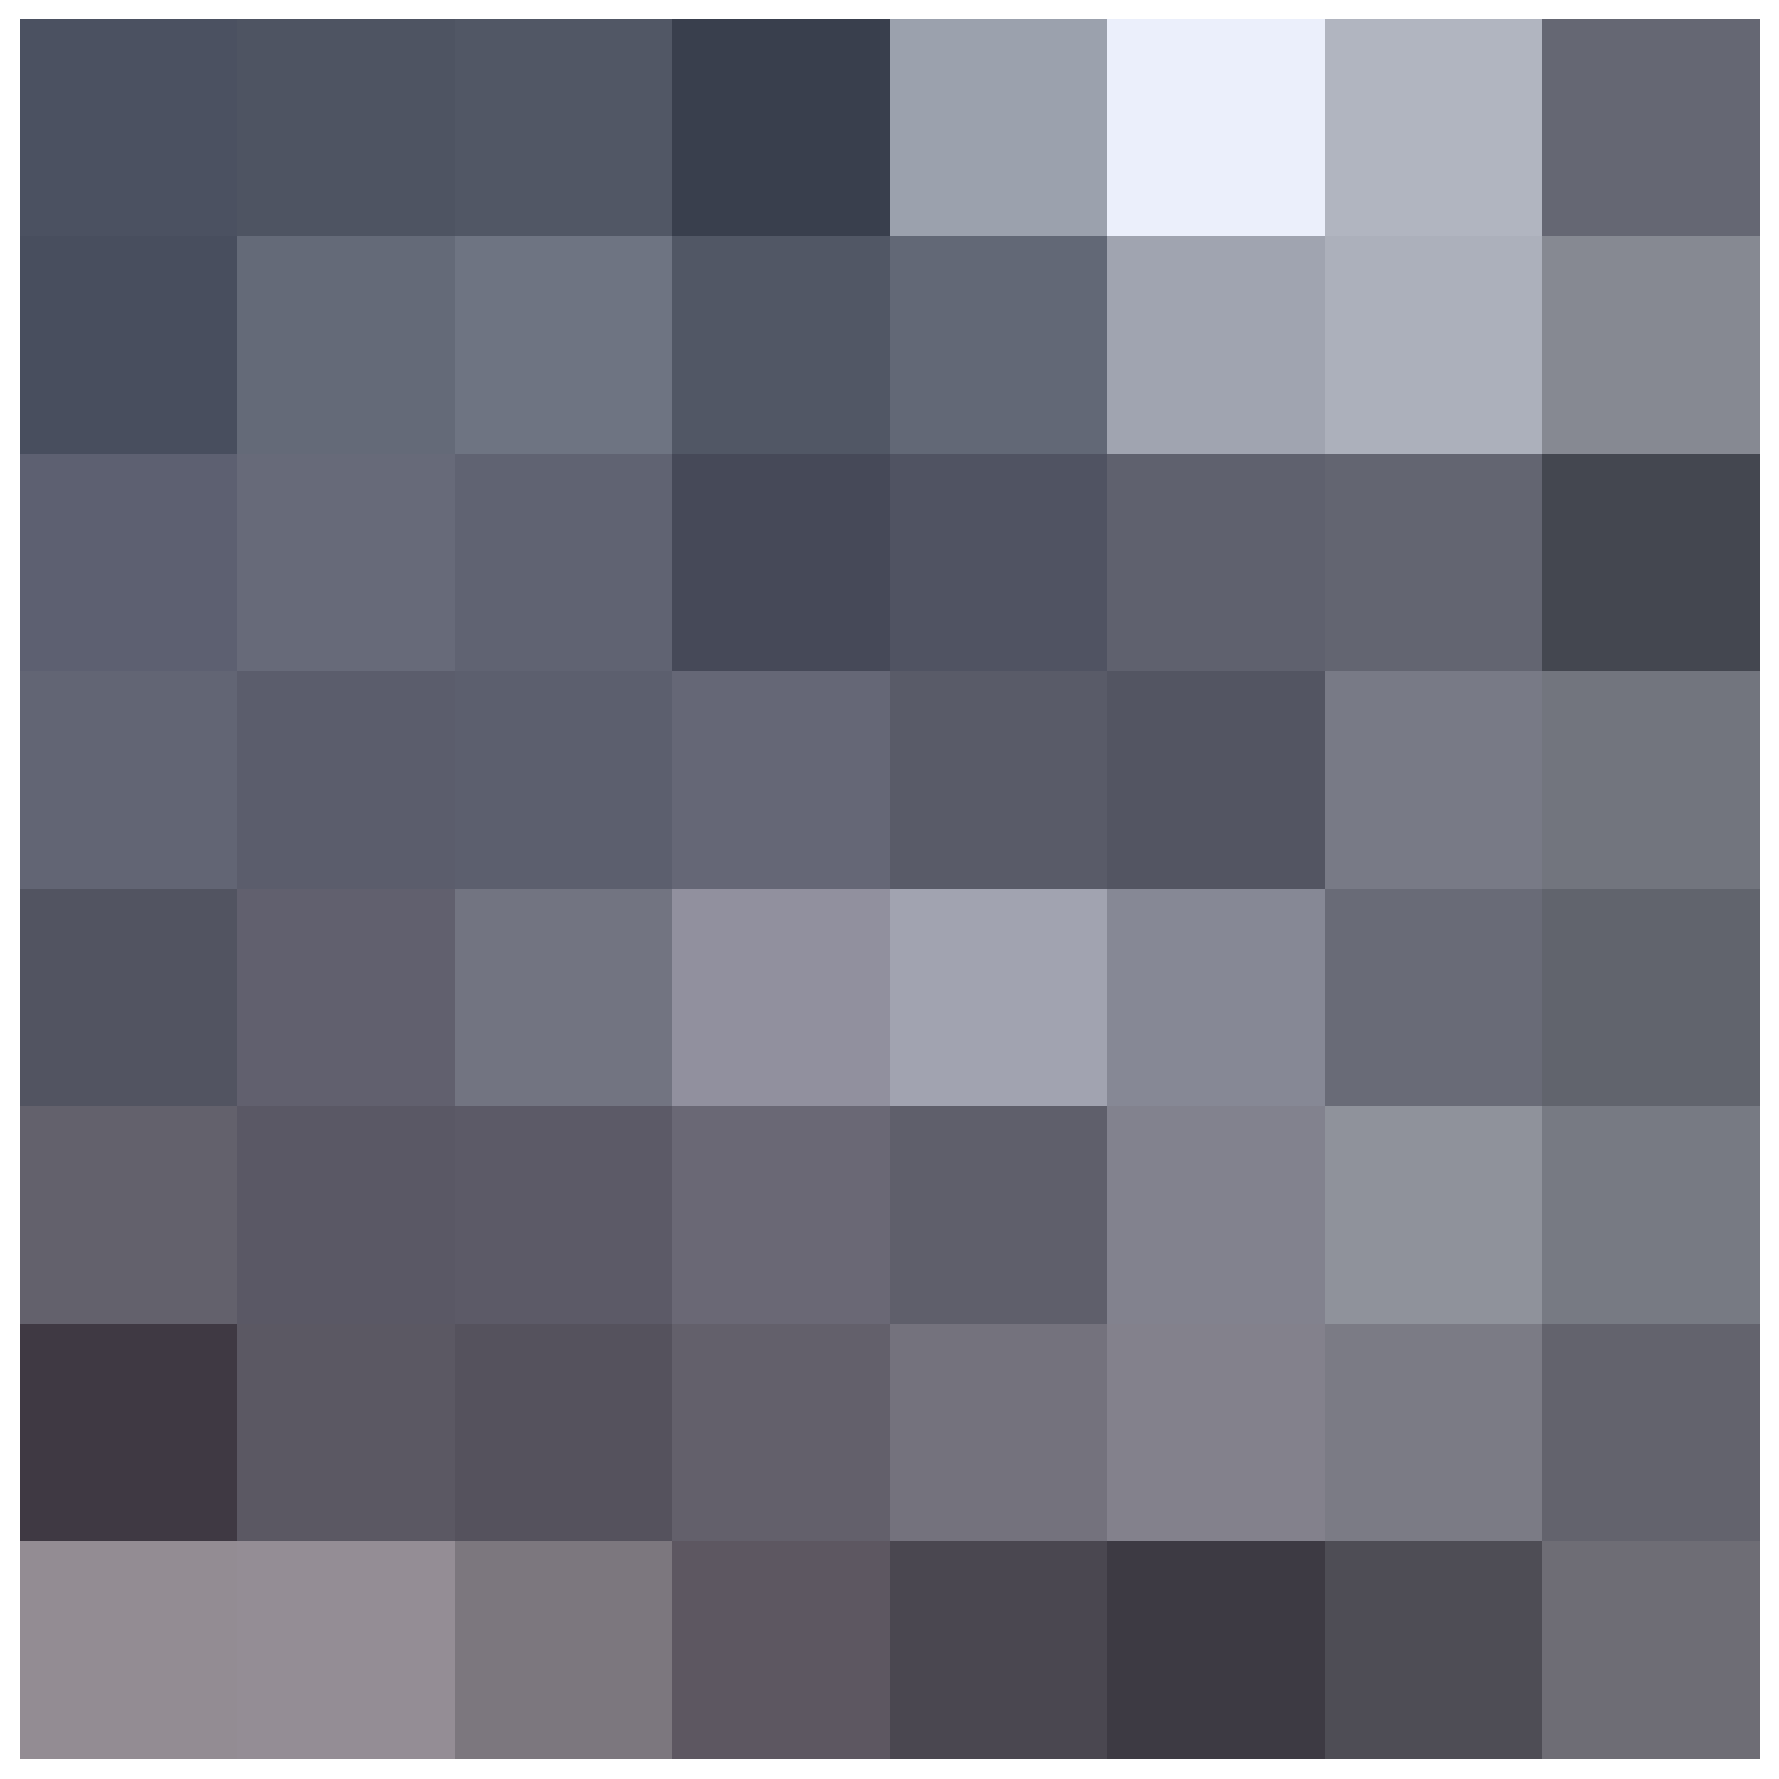

In [6]:
show_extreme_area(nwpu_max_counts_8, 8, "nwpu", "deeppink")